In [63]:
import json
import requests
import re
from datetime import datetime

import pandas as pd
import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score

import pickle
import math

In [64]:
BASE_URL = 'https://api.opendota.com/api/'
TEAMS = 'teams'
HEROES = 'heroes'
PROPLAYERS = 'proPlayers'
PROMATCHES = 'proMatches'
MATCHES = 'matches'
PLAYERS = 'players'
HEROES_STATS = 'heroStats'

In [75]:
# read team OG matches file
with open(r'C:\Users\johnp\Documents\ESportsAnalytics\team_og_matches.json', 'r', encoding="utf-8") as input_file:

    data = input_file.read()
    team_og_matches_json = json.loads(data)

In [66]:
def match_outcome(radiant_win, radiant):
    if ((radiant_win == False and radiant == False) or (radiant_win == True and radiant == True)):
        return True
    
    elif ((radiant_win == True and radiant == False) or (radiant_win == False and radiant == True)):
        return False

In [67]:
error_list = []

for index, item in enumerate(team_og_matches_json):

    predict_players_mmr_total = 0
    predict_players_mmr_count = 0
    for x, i in enumerate(item['predict_players']):

        try:
            predict_players_mmr_total += i['player_stats']['mmr_estimate']['estimate']
            predict_players_mmr_count += 1

        except:

            error_list.append(index)
            
    # get the average MMR of the team
    team_og_matches_json[index]['predict_players_mmr_average'] = predict_players_mmr_total / predict_players_mmr_count

    opposing_players_mmr_total = 0
    opposing_players_mmr_count = 0
    for y, j in enumerate(item['opposing_players']):

        try:
            opposing_players_mmr_total += j['player_stats']['mmr_estimate']['estimate']
            opposing_players_mmr_count += 1

        except:

            error_list.append(index)
            
    team_og_matches_json[index]['opposing_players_mmr_average'] = opposing_players_mmr_total / opposing_players_mmr_count
    
    
    predict_team_total_matches = item['predict_team_stat'][0]['predict_team_wins_total'] + item['predict_team_stat'][0]['predict_team_losses_total']
    team_og_matches_json[index]['predict_team_total_matches'] = predict_team_total_matches
    
    predict_team_win_pct = round(item['predict_team_stat'][0]['predict_team_wins_total'] / predict_team_total_matches * 100, 2)
    team_og_matches_json[index]['predict_team_win_pct'] = predict_team_win_pct
    
    opposing_team_total_matches = item['opposing_team_stat'][0]['opposing_team_wins_total'] + item['opposing_team_stat'][0]['opposing_team_losses_total']
    team_og_matches_json[index]['opposing_team_total_matches'] = opposing_team_total_matches 
    
    opposing_team_win_pct =  round(item['opposing_team_stat'][0]['opposing_team_wins_total'] / opposing_team_total_matches * 100, 2)
    team_og_matches_json[index]['opposing_team_win_pct'] = opposing_team_win_pct

In [76]:
for i in team_og_matches_json[0]:
    print(i)

match_id
radiant_win
radiant
duration
start_time
leagueid
league_name
cluster
opposing_team_id
opposing_team_name
opposing_team_logo
predict_players
opposing_players
opposing_team_stat
predict_team_stat


In [84]:
team_og_matches_json[0]['predict_players']

[{'account_id': 183719386,
  'name': 'AMMAR_THE_F',
  'player_stats': {'rank_tier': 80,
   'profile': {'account_id': 183719386,
    'personaname': 'malrine main)',
    'name': 'AMMAR_THE_F',
    'plus': True,
    'cheese': 0,
    'steamid': '76561198143985114',
    'avatar': 'https://avatars.akamai.steamstatic.com/6dde62ad2f5e6d32c9d0b7432313ce82c189bf30.jpg',
    'avatarmedium': 'https://avatars.akamai.steamstatic.com/6dde62ad2f5e6d32c9d0b7432313ce82c189bf30_medium.jpg',
    'avatarfull': 'https://avatars.akamai.steamstatic.com/6dde62ad2f5e6d32c9d0b7432313ce82c189bf30_full.jpg',
    'profileurl': 'https://steamcommunity.com/id/THE_FUCKER-RETURN/',
    'last_login': '2021-05-05T15:49:21.412Z',
    'loccountrycode': 'JO',
    'status': None,
    'is_contributor': False,
    'is_subscriber': False},
   'solo_competitive_rank': 3333,
   'leaderboard_rank': 41,
   'competitive_rank': None,
   'mmr_estimate': {'estimate': 5001}}},
 {'account_id': 93618577,
  'name': 'bzm',
  'player_stats':

In [78]:
X.head(1)

,predict_team_total_matches,predict_team_win_pct,predict_team_rating,predict_players_mmr_average,opposing_team_total_matches,opposing_team_win_pct,opposing_team_rating,opposing_players_mmr_average
0,1325,61.66,1554.93,6058.8,903,54.93,1493.25,7204.6


In [94]:
def get_team_profile(team_matches_dict, predict_or_opposing):

    predict_players_mmr_total = 0
    predict_players_mmr_count = 0

    for x, i in enumerate(team_matches_dict['predict_players']):

        try:
            predict_players_mmr_total += i['player_stats']['mmr_estimate']['estimate']
            predict_players_mmr_count += 1

        except:

            error_list.append(index)
            
    # get the average MMR of the team
    predict_players_mmr_average = predict_players_mmr_total / predict_players_mmr_count

    predict_team_total_matches = team_matches_dict['predict_team_stat'][0]['predict_team_wins_total'] + team_matches_dict['predict_team_stat'][0]['predict_team_losses_total']
    
    predict_team_win_pct = round(team_matches_dict['predict_team_stat'][0]['predict_team_wins_total'] / predict_team_total_matches * 100, 2)

    return pd.DataFrame(data = {predict_or_opposing + '_team_total_matches' : predict_team_total_matches, 
                                predict_or_opposing + '_team_win_pct' : predict_team_win_pct, 
                                predict_or_opposing + '_team_rating' : team_matches_dict['predict_team_stat'][0]['predict_team_rating'], 
                                predict_or_opposing + '_players_mmr_average' : predict_players_mmr_average}, 
                        index = [0]) 
                   

In [97]:
og_team_profile_df = get_team_profile(team_og_matches_json[0], 'opposing')

In [98]:
og_team_profile_df

,opposing_team_total_matches,opposing_team_win_pct,opposing_team_rating,opposing_players_mmr_average
0,1325,61.66,1554.93,6058.8


In [74]:
team_og_matches_json[0]

{'match_id': 6728572058,
 'radiant_win': True,
 'radiant': True,
 'duration': 2455,
 'start_time': 1661683040,
 'leagueid': 14388,
 'league_name': 'ESL One Malaysia 2022 powered by Intel',
 'cluster': 155,
 'opposing_team_id': 6209166,
 'opposing_team_name': 'Team Aster',
 'opposing_team_logo': 'https://steamusercontent-a.akamaihd.net/ugc/1629730253163462144/FEF15B2B4528E81103DD693E37FD7B6C9BE6B471/',
 'predict_players': [{'account_id': 183719386,
   'name': 'AMMAR_THE_F',
   'player_stats': {'rank_tier': 80,
    'profile': {'account_id': 183719386,
     'personaname': 'malrine main)',
     'name': 'AMMAR_THE_F',
     'plus': True,
     'cheese': 0,
     'steamid': '76561198143985114',
     'avatar': 'https://avatars.akamai.steamstatic.com/6dde62ad2f5e6d32c9d0b7432313ce82c189bf30.jpg',
     'avatarmedium': 'https://avatars.akamai.steamstatic.com/6dde62ad2f5e6d32c9d0b7432313ce82c189bf30_medium.jpg',
     'avatarfull': 'https://avatars.akamai.steamstatic.com/6dde62ad2f5e6d32c9d0b7432313c

In [ ]:
# Convert the team matches json to a dataframe
def team_matches_df(team_matches_json, predict_team_name, predict_team_id):
    
    all_matches_df = pd.DataFrame(data = [(datetime.fromtimestamp(item['start_time']).strftime('%Y-%m-%d %H:%M:%S'),
                                                       predict_team_name,
                                                       predict_team_id,
                                                       item['predict_team_total_matches'],
                                                       item['predict_team_win_pct'],
                                                       item['predict_team_stat'][0]['predict_team_rating'],
                                                       item['predict_players_mmr_average'],
                                                       item['opposing_team_name'],
                                                       item['opposing_team_id'],
                                                       item['opposing_team_total_matches'],
                                                       item['opposing_team_win_pct'],
                                                       item['opposing_team_stat'][0]['opposing_team_rating'],
                                                       item['opposing_players_mmr_average'],
                                                       item['league_name'],
                                                       item['leagueid'],
                                                       item['cluster'], 
                                                       item['radiant_win'],
                                                       item['radiant'],
                                                       item['duration'], 
                                                       item['match_id'],
                                                       match_outcome(item['radiant_win'], item['radiant'])) for index, item in enumerate(team_matches_json)], 
                      columns = ['start_date', 
                                 'predict_team_name', 
                                 'predict_team_id', 
                                 'predict_team_total_matches', 
                                 'predict_team_win_pct',
                                 'predict_team_rating',   
                                 'predict_players_mmr_average', 
                                 'opposing_team_name', 
                                 'opposing_team_id', 
                                 'opposing_team_total_matches',
                                 'opposing_team_win_pct', 
                                 'opposing_team_rating',
                                 'opposing_players_mmr_average', 
                                 'league_name', 
                                 'leagueid', 
                                 'cluster', 
                                 'radiant_win', 
                                 'radiant', 
                                 'duration', 
                                 'match_id', 
                                 'match_outcome'])
    
    return all_matches_df


In [ ]:
og_team_matches_df = team_matches_df(team_og_matches_json, 'OG', 2586976)

In [ ]:
og_team_matches_df.shape

(1335, 21)

In [ ]:
og_team_matches_df.head()

,start_date,predict_team_name,predict_team_id,predict_team_total_matches,predict_team_win_pct,predict_team_rating,predict_players_mmr_average,opposing_team_name,opposing_team_id,opposing_team_total_matches,...,opposing_team_rating,opposing_players_mmr_average,league_name,leagueid,cluster,radiant_win,radiant,duration,match_id,match_outcome
0,2022-08-28 20:37:20,OG,2586976,1325,61.66,1554.93,6058.8,Team Aster,6209166,903,...,1493.25,7204.6,ESL One Malaysia 2022 powered by Intel,14388,155,True,True,2455,6728572058,True
1,2022-08-28 19:19:19,OG,2586976,1325,61.66,1554.93,6058.8,Team Aster,6209166,903,...,1493.25,7204.6,ESL One Malaysia 2022 powered by Intel,14388,155,False,False,2996,6728463079,True
2,2022-08-28 18:03:26,OG,2586976,1325,61.66,1554.93,6058.8,Team Aster,6209166,903,...,1493.25,7204.6,ESL One Malaysia 2022 powered by Intel,14388,151,False,False,2776,6728333090,True
3,2022-08-28 15:18:42,OG,2586976,1325,61.66,1554.93,6058.8,Team Secret,1838315,1489,...,1405.11,6524.6,ESL One Malaysia 2022 powered by Intel,14388,151,False,False,1628,6728136960,True
4,2022-08-28 14:04:20,OG,2586976,1325,61.66,1554.93,6058.8,Team Secret,1838315,1489,...,1405.11,6524.6,ESL One Malaysia 2022 powered by Intel,14388,156,False,False,2547,6728055442,True


In [ ]:
og_team_matches_df.shape

(1335, 21)

In [ ]:
og_team_matches_df.describe()

,predict_team_id,predict_team_total_matches,predict_team_win_pct,predict_team_rating,predict_players_mmr_average,opposing_team_id,opposing_team_total_matches,opposing_team_win_pct,opposing_team_rating,opposing_players_mmr_average,leagueid,cluster,duration,match_id
count,1335.0,1335.0,1.335000e+03,1335.00,1335.000000,1.335000e+03,1335.000000,1335.000000,1335.000000,1335.000000,1335.000000,1335.000000,1335.000000,1.335000e+03
mean,2586976.0,1325.0,6.166000e+01,1554.93,7197.969251,3.048439e+06,1129.161798,55.585311,1250.497546,6810.475356,9137.111610,162.788015,2190.968539,4.314633e+09
std,0.0,0.0,1.421618e-14,0.00,450.029236,3.001297e+06,864.457613,7.942957,142.841054,424.069647,3711.320641,52.860053,627.952251,1.480746e+09
min,2586976.0,1325.0,6.166000e+01,1554.93,5986.200000,3.000000e+00,1.000000,0.000000,803.612000,4142.200000,3534.000000,111.000000,623.000000,1.909728e+09
25%,2586976.0,1325.0,6.166000e+01,1554.93,7208.800000,1.114740e+05,247.000000,53.770000,1138.165000,6556.600000,5157.000000,132.000000,1764.000000,3.092698e+09
50%,2586976.0,1325.0,6.166000e+01,1554.93,7367.000000,1.883502e+06,1090.000000,56.990000,1262.990000,6819.800000,10158.000000,136.000000,2103.000000,4.243971e+09
75%,2586976.0,1325.0,6.166000e+01,1554.93,7447.400000,6.209166e+06,1990.000000,59.620000,1355.530000,7128.400000,12397.000000,185.000000,2552.000000,5.628478e+09
max,2586976.0,1325.0,6.166000e+01,1554.93,7574.800000,8.724984e+06,2491.000000,75.000000,1603.120000,7752.800000,14417.000000,308.000000,5191.000000,6.728572e+09


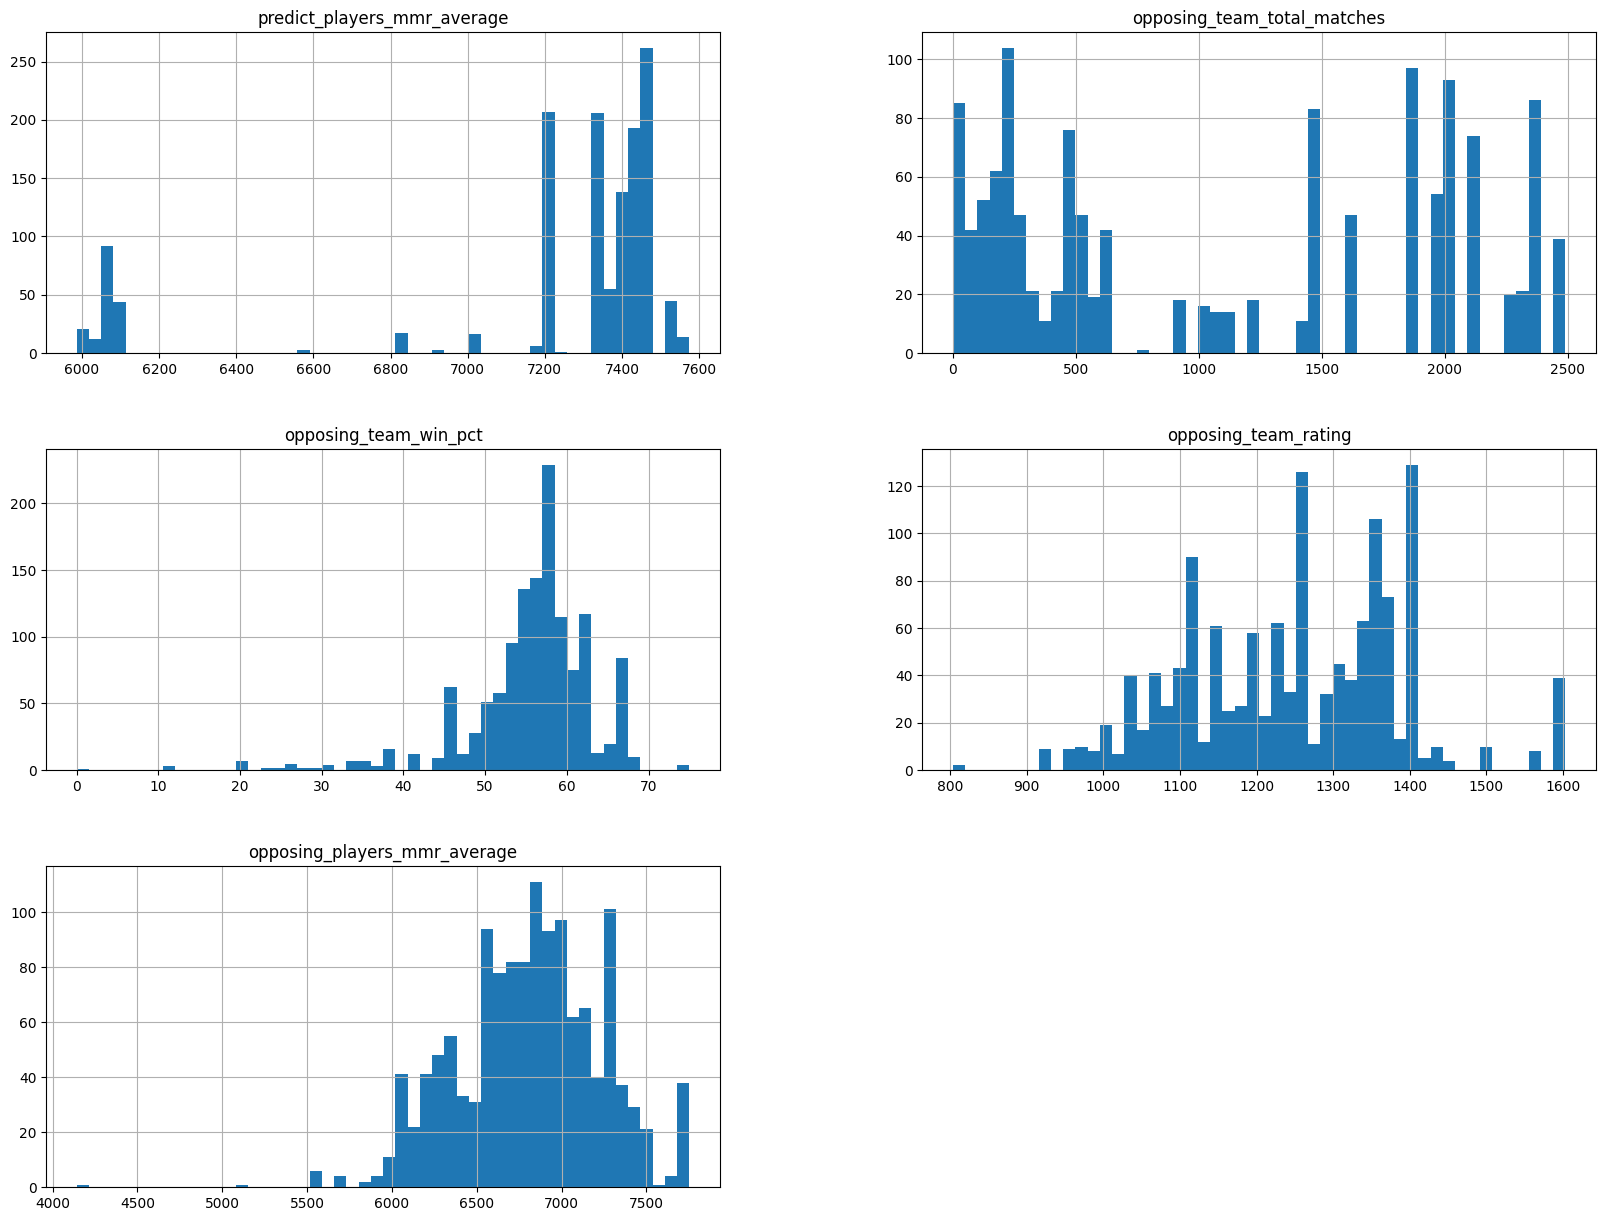

In [ ]:
og_team_matches_df.loc[:,['predict_players_mmr_average', 
                   'opposing_team_total_matches', 
                   'opposing_team_win_pct', 
                   'opposing_team_rating', 
                   'opposing_players_mmr_average']].hist(bins = 50, figsize=(20, 15))
plt.show()

In [ ]:
og_team_matches_df.columns

Index(['start_date', 'predict_team_name', 'predict_team_id',
       'predict_team_total_matches', 'predict_team_win_pct',
       'predict_team_rating', 'predict_players_mmr_average',
       'opposing_team_name', 'opposing_team_id', 'opposing_team_total_matches',
       'opposing_team_win_pct', 'opposing_team_rating',
       'opposing_players_mmr_average', 'league_name', 'leagueid', 'cluster',
       'radiant_win', 'radiant', 'duration', 'match_id', 'match_outcome'],
      dtype='object')

In [ ]:
X = og_team_matches_df.drop(labels = ['match_outcome', 
                                      'start_date', 
                                      'predict_team_name',
                                      'predict_team_id',
                                      'opposing_team_name',
                                      'opposing_team_id',
                                      'league_name',
                                      'leagueid',
                                      'cluster', 
                                      'radiant_win', 
                                      'radiant', 
                                      'match_id', 
                                      'duration'], axis = 1)

y = og_team_matches_df.match_outcome

# Consider scaling the data (Normalisation or Standardisation)

In [ ]:
X.head()

,predict_team_total_matches,predict_team_win_pct,predict_team_rating,predict_players_mmr_average,opposing_team_total_matches,opposing_team_win_pct,opposing_team_rating,opposing_players_mmr_average
0,1325,61.66,1554.93,6058.8,903,54.93,1493.25,7204.6
1,1325,61.66,1554.93,6058.8,903,54.93,1493.25,7204.6
2,1325,61.66,1554.93,6058.8,903,54.93,1493.25,7204.6
3,1325,61.66,1554.93,6058.8,1489,66.69,1405.11,6524.6
4,1325,61.66,1554.93,6058.8,1489,66.69,1405.11,6524.6


In [ ]:
X.columns

Index(['predict_team_total_matches', 'predict_team_win_pct',
       'predict_team_rating', 'predict_players_mmr_average',
       'opposing_team_total_matches', 'opposing_team_win_pct',
       'opposing_team_rating', 'opposing_players_mmr_average'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred = log_reg.predict(X_test)

In [ ]:
conf_mtx = confusion_matrix(y_test, y_pred)

In [ ]:
conf_mtx

array([[ 40,  54],
       [ 28, 145]], dtype=int64)

# Explanation

[[True Negative, False Positive],

 [False Negative, True Positive]]
 
In the first row, the model CORRECTLY predicted 40 losses, but INCORRECTLY predicted 54 wins (it should have been losses)

In the second row, the model INCORRECTLY predicted 28 losses (it should have been wins), while it CORRECTLY predicted 145 wins
 


In [ ]:
precision_score(y_test, y_pred)

0.7286432160804021

The Logistic Regression model can CORRECTLY predict WINS 71.77% of the time

In [ ]:
recall_score(y_test, y_pred)

0.838150289017341

Save the Logistic Regression as a Pickle File

pickle.dump(log_reg, open('og_log_reg.pkl', 'wb'))

In [ ]:
X_test[0:5]

,predict_team_total_matches,predict_team_win_pct,predict_team_rating,predict_players_mmr_average,opposing_team_total_matches,opposing_team_win_pct,opposing_team_rating,opposing_players_mmr_average,duration
898,1325,61.66,1554.93,7208.8,350,45.71,1142.55,7044.8,3318
1062,1325,61.66,1554.93,7462.2,177,48.02,1186.71,6539.8,1902
1253,1325,61.66,1554.93,7447.4,1883,59.00,1355.53,7501.0,2343
298,1325,61.66,1554.93,7397.4,1883,59.00,1355.53,7128.4,1936
237,1325,61.66,1554.93,7343.8,400,53.50,1334.85,6490.6,2352


In [ ]:
y_test[0:5]

898      True
1062    False
1253    False
298     False
237      True
Name: match_outcome, dtype: bool

In [ ]:
y_pred[0:5]

array([ True,  True, False, False,  True])

In [ ]:
X_test.iloc[1, :]

predict_team_total_matches      1325.00
predict_team_win_pct              61.66
predict_team_rating             1554.93
predict_players_mmr_average     7462.20
opposing_team_total_matches      177.00
opposing_team_win_pct             48.02
opposing_team_rating            1186.71
opposing_players_mmr_average    6539.80
duration                        1902.00
Name: 1062, dtype: float64

In [ ]:
test_list = []
for item in X_test.iloc[1, :]:
    test_list.append(item)

In [ ]:
log_reg.predict([test_list])

c:\Users\johnp\deploy-mlmodel\deploy-mlmodel-env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([ True])

In [ ]:
number = 12345

In [ ]:
print(f'number is: {number}')

number is: 12345


In [ ]:
predict_team = {'1838315' : 'Team Secret', 
                    '2586976' : 'OG', 
                    '2163' : 'Team Liquid', 
                    '7732977' : 'Boom Esports', 
                    '15' : 'PSG.LGD', 
                    '7119388' : 'Team Spirit', 
                    '8254400' : 'Beastcoast', 
                    '6209166' : 'Team Aster', 
                    '7391077' : 'Thunder Awaken', 
                    '8260983' : 'TSM', 
                    '8291895' : 'Tundra Esports', 
                    '7390454' : 'Soniqs', 
                    '8599101' : 'Gaimin Gladiators', 
                    '39' : 'Evil Geniuses', 
                    '350190' : 'Fnatic', 
                    '8131728' : 'Hokori', 
                    '8605863' : 'Entity', 
                    '8721219' : 'BetBoom Team', 
                    '6209804' : 'Royal Never Give Up', 
                    '8597976' : 'Talon Esports'} 

In [ ]:
for key, value in predict_team.items():
    print(key, value)

1838315 Team Secret
2586976 OG
2163 Team Liquid
7732977 Boom Esports
15 PSG.LGD
7119388 Team Spirit
8254400 Beastcoast
6209166 Team Aster
7391077 Thunder Awaken
8260983 TSM
8291895 Tundra Esports
7390454 Soniqs
8599101 Gaimin Gladiators
39 Evil Geniuses
350190 Fnatic
8131728 Hokori
8605863 Entity
8721219 BetBoom Team
6209804 Royal Never Give Up
8597976 Talon Esports
